# Inception V3

In [1]:
# Importing neccessary packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import json
from utils import add_regularization, get_data_generators, plot_model_results
from Models import TrainingCheckpoint, ModelTrain

In [2]:
NUM_CLASSES = 11
with open('classes_list.json', 'r') as fp:
    classes_list = json.load(fp)

In [3]:
# Data augmentation for regularization and adding some extra training samples

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    rescale=1.0/255.0,
    horizontal_flip=True, 
    zoom_range=0.2,
    shear_range=0.2
)

In [4]:
TARGET_DIM = 300
BATCH_SIZE = 128

In [5]:
train_generator, validation_generator = get_data_generators(datagen, TARGET_DIM, BATCH_SIZE)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.


In [6]:
base_model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False, 
    weights='imagenet', 
    input_shape=(TARGET_DIM, TARGET_DIM, 3)
)

In [7]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
print('Layers in InceptionV3: ' + str(len(base_model.layers)))

Layers in InceptionV3: 311


In [9]:
preds = base_model.output
preds = tf.keras.layers.GlobalAveragePooling2D()(preds)
preds = tf.keras.layers.Dense(1024, activation=tf.nn.relu)(preds)
preds = tf.keras.layers.BatchNormalization()(preds)
preds = tf.keras.layers.Dense(512, activation=tf.nn.relu)(preds)
preds = tf.keras.layers.BatchNormalization()(preds)
preds = tf.keras.layers.Dense(256, activation=tf.nn.relu)(preds)
preds = tf.keras.layers.BatchNormalization()(preds)
preds = tf.keras.layers.Dense(128, activation=tf.nn.relu)(preds)
preds = tf.keras.layers.Dense(11, activation=tf.nn.softmax)(preds)

In [10]:
model = tf.keras.models.Model(base_model.input, preds)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
inceptionV3 = ModelTrain(model, TARGET_DIM, BATCH_SIZE)
inceptionV3.freeze_layers(9)

In [13]:
inceptionV3.model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [14]:
# Moniter training_acc
filepath="./models/inceptionV3-{epoch:02d}-{acc:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')

training_checkpoint = TrainingCheckpoint()

csv_logger = tf.keras.callbacks.CSVLogger(filename='./logs/inceptionV3_training.csv', append=True)

In [15]:
# Training the model for 60 epochs
inceptionV3.model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, csv_logger, training_checkpoint],
    epochs=60
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/60
77/77 [==============================] - ETA: 0s - loss: 0.8779 - acc: 0.7068 
Epoch 00001: acc improved from -inf to 0.70682, saving model to ./models/inceptionV3-01-0.71.hdf5
77/77 [==============================] - 1379s 18s/step - loss: 0.8779 - acc: 0.7068 - val_loss: 1.4189 - val_acc: 0.5424
Epoch 2/60
77/77 [==============================] - ETA: 0s - loss: 0.5626 - acc: 0.8108 
Epoch 00002: acc improved from 0.70682 to 0.81084, saving model to ./models/inceptionV3-02-0.81.hdf5
77/77 [==============================] - 1491s 19s/step - loss: 0.5626 - acc: 0.8108 - val_loss: 0.8979 - val_acc: 0.7001
Epoch 3/60
77/77 [==============================] - ETA: 0s - loss: 0.4654 - acc: 0.8460 
Epoch 00003: acc improved from 0.81084 to 0.84596, saving model to ./models/inceptionV3-03-0.85.hdf5
77/77 [==============================] - 1481s 19s/step - loss: 0.4654 - acc: 0.8460 - val_loss: 0.7436 - val_

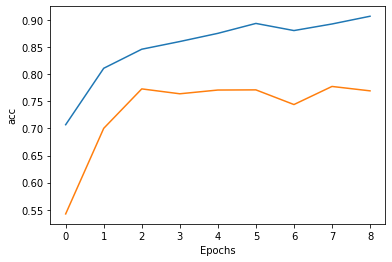

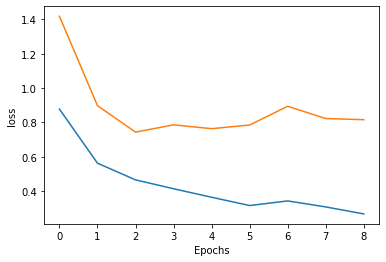

In [16]:
plot_model_results(9, model.history.history, 'acc')
plot_model_results(9, model.history.history, 'loss')

### Results

Training accuracy: 0.9068<br>
Training loss: 0.2670<br>

Validation accuracy: 0.7692<br>
Validation loss: 0.8160

Avoidable bias: 0.0932 => 9.32%<br>
Variance: 0.1308 => 13.08%<br>

### Conclusion:
Variance is higher than bias so we need to regularize the model.

## Data augmentation

In [20]:
%%time
model = tf.keras.models.load_model('./models/inceptionV3-09-0.91.hdf5')

Wall time: 4.89 s


In [21]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    rescale=1.0/255.0,
    horizontal_flip=True, 
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=30
)

In [22]:
train_generator, validation_generator = get_data_generators(datagen, TARGET_DIM, BATCH_SIZE)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.


In [25]:
filepath="./models/inceptionV3-regularized-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

training_checkpoint = TrainingCheckpoint()

csv_logger = tf.keras.callbacks.CSVLogger(filename='./logs/inceptionV3_regularize.csv', append=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', patience=2)

## Kernel regularization

In [26]:
## Adding weight regularization to dense_1 and dense_3 layers.
weight_regularization_layers = [model.layers[-2], model.layers[-6]]
model = add_regularization(model, weight_regularization_layers, regularizer=tf.keras.regularizers.l2(l=0.003))

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [28]:
model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, csv_logger, training_checkpoint, early_stopping],
    epochs=20
)

Epoch 1/20
77/77 [==============================] - ETA: 0s - loss: 2.2745 - acc: 0.8372 
Epoch 00001: val_acc improved from -inf to 0.73407, saving model to ./models/inceptionV3-regularized-01-0.73.hdf5
77/77 [==============================] - 1284s 17s/step - loss: 2.2745 - acc: 0.8372 - val_loss: 2.0141 - val_acc: 0.7341
Epoch 2/20
77/77 [==============================] - ETA: 0s - loss: 1.3857 - acc: 0.8610 
Epoch 00002: val_acc improved from 0.73407 to 0.76202, saving model to ./models/inceptionV3-regularized-02-0.76.hdf5
77/77 [==============================] - 1226s 16s/step - loss: 1.3857 - acc: 0.8610 - val_loss: 1.5705 - val_acc: 0.7620
Epoch 3/20
77/77 [==============================] - ETA: 0s - loss: 1.0850 - acc: 0.8656 
Epoch 00003: val_acc did not improve from 0.76202
77/77 [==============================] - 1268s 16s/step - loss: 1.0850 - acc: 0.8656 - val_loss: 1.3035 - val_acc: 0.7602
Epoch 4/20
77/77 [==============================] - ETA: 0s - loss: 0.9207 - acc: 0

### Results

Training accuracy: 0.8610<br>
Training loss: 1.3857<br>

Validation accuracy: 0.7620<br>
Validation loss: 1.5705

Avoidable bias: 0.1390 => 13.9%<br>
Variance: 0.099 => 9.9%<br>

### Conclusion:

The model val_acc is not improving above the 77% as we see in vgg19 model so let's try to reduce variance to improve the model by adding dropout layers.

## Dropout regularization

In [37]:
%%time
model = tf.keras.models.load_model('./models/inceptionV3-regularized-02-0.76.hdf5')

Wall time: 4.84 s


In [43]:
preds = model.layers[-8].output
preds = tf.keras.layers.Dropout(rate=0.4)(preds)
preds = model.layers[-7](preds)
preds = model.layers[-6](preds)
preds = model.layers[-5](preds)
preds = model.layers[-4](preds)
preds = tf.keras.layers.Dropout(rate=0.3)(preds)
preds = model.layers[-3](preds)
preds = model.layers[-2](preds)
preds = model.layers[-1](preds)

In [44]:
model = tf.keras.models.Model(model.input, preds)

In [45]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [46]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, csv_logger, training_checkpoint],
    epochs=15
)

Epoch 1/15
77/77 [==============================] - ETA: 0s - loss: 1.3315 - acc: 0.7897 
Epoch 00001: val_acc improved from 0.76202 to 0.77133, saving model to ./models/inceptionV3-regularized-01-0.77.hdf5
77/77 [==============================] - 1246s 16s/step - loss: 1.3315 - acc: 0.7897 - val_loss: 1.3019 - val_acc: 0.7713
Epoch 2/15
77/77 [==============================] - ETA: 0s - loss: 1.0980 - acc: 0.8174 
Epoch 00002: val_acc improved from 0.77133 to 0.78756, saving model to ./models/inceptionV3-regularized-02-0.79.hdf5
77/77 [==============================] - 1233s 16s/step - loss: 1.0980 - acc: 0.8174 - val_loss: 1.1438 - val_acc: 0.7876
Epoch 3/15
77/77 [==============================] - ETA: 0s - loss: 0.9591 - acc: 0.8337 
Epoch 00003: val_acc improved from 0.78756 to 0.82332, saving model to ./models/inceptionV3-regularized-03-0.82.hdf5
77/77 [==============================] - 1291s 17s/step - loss: 0.9591 - acc: 0.8337 - val_loss: 0.9549 - val_acc: 0.8233
Epoch 4/15
77

### Results:

Training accuracy: 0.8337<br>
Training loss: 0.9591<br>

Validation accuracy: 0.8233<br>
Validation loss: 0.9549<br>

Avoidable bias: 0.1663 => 16.63%<br>
Variance: 0.0104 => 1.04%<br>

### Conclusion
This model is very well generalized with only 1% of variance error. This model has shown to better perform on validation data then the vgg19 model.